In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pylab import rcParams
from datetime import datetime,timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Importing required libraries and loading the dataset.

***`Data preparation`***

In [6]:
import pandas                             as      pd
df=pd.read_csv("CSUSHPISA.csv")
df.head()

,DATE,CSUSHPISA
0,1/1/1987,63.965
1,2/1/1987,64.424
2,3/1/1987,64.735
3,4/1/1987,65.132
4,5/1/1987,65.565


In [7]:
df.tail()

,DATE,CSUSHPISA
420,1/1/2022,284.767
421,2/1/2022,290.371
422,3/1/2022,296.496
423,4/1/2022,301.704
424,5/1/2022,304.831


In [8]:
df.shape

(425, 2)

In [9]:
df.dtypes

DATE          object
CSUSHPISA    float64
dtype: object

In [10]:
date=pd.date_range(start='1/1/1987',end='8/1/2022',freq='M')
date

DatetimeIndex(['1987-01-31', '1987-02-28', '1987-03-31', '1987-04-30',
               '1987-05-31', '1987-06-30', '1987-07-31', '1987-08-31',
               '1987-09-30', '1987-10-31',
               ...
               '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31'],
              dtype='datetime64[ns]', length=427, freq='M')

In [11]:
date.shape

(427,)

In [12]:
df['Time_stamp']=pd.DataFrame(date)
df=df.set_index('Time_stamp')
df.head()

,DATE,CSUSHPISA
Time_stamp,,
1987-01-31,1/1/1987,63.965
1987-02-28,2/1/1987,64.424
1987-03-31,3/1/1987,64.735
1987-04-30,4/1/1987,65.132
1987-05-31,5/1/1987,65.565


In [13]:
df.tail()

,DATE,CSUSHPISA
Time_stamp,,
2022-01-31,1/1/2022,284.767
2022-02-28,2/1/2022,290.371
2022-03-31,3/1/2022,296.496
2022-04-30,4/1/2022,301.704
2022-05-31,5/1/2022,304.831


In [14]:
df1=df.drop(['DATE'],axis=1)

In [15]:
df1.head()

,CSUSHPISA
Time_stamp,
1987-01-31,63.965
1987-02-28,64.424
1987-03-31,64.735
1987-04-30,65.132
1987-05-31,65.565


In [16]:
df1.isnull().sum()

CSUSHPISA    0
dtype: int64

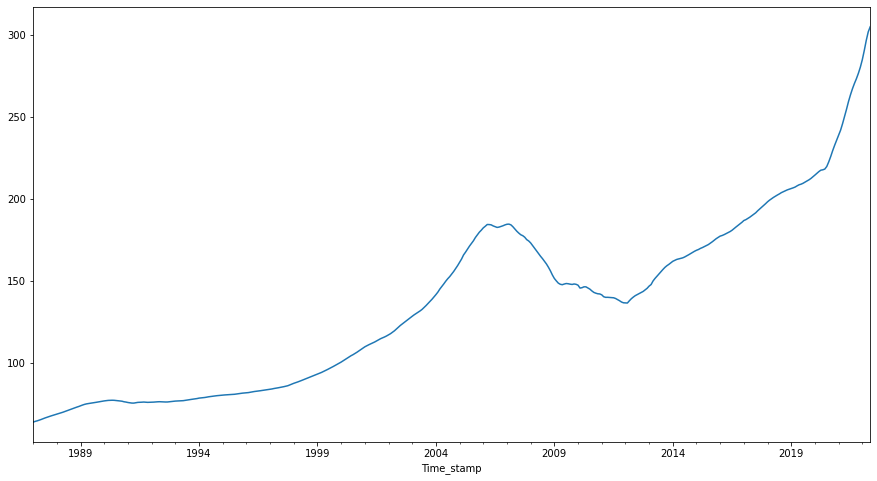

In [17]:
rcParams['figure.figsize']=15,8
df1['CSUSHPISA'].plot()

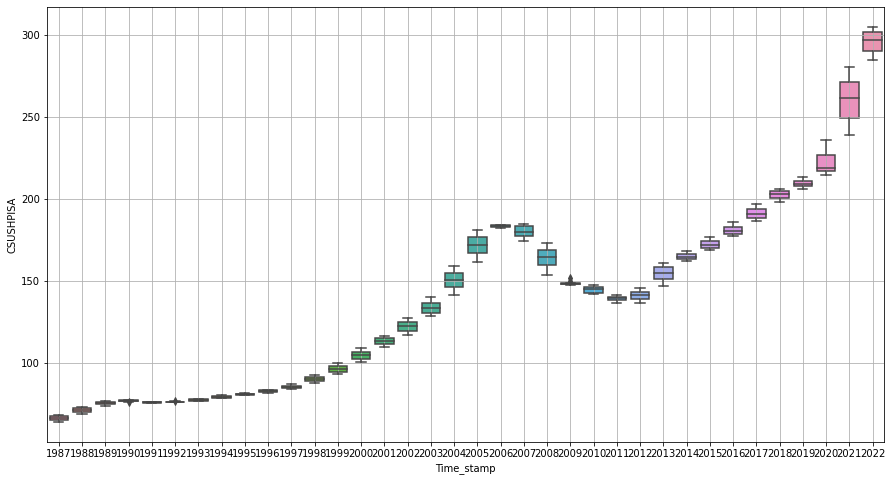

In [18]:
sns.boxplot(x=df1.index.year,y=df1['CSUSHPISA'])
plt.grid();

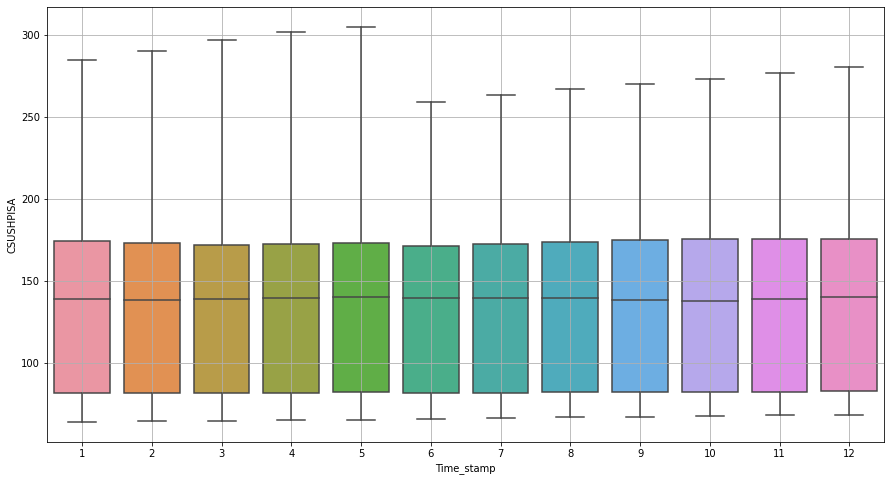

In [19]:
sns.boxplot(x=df1.index.month,y=df1['CSUSHPISA'])
plt.grid();

***Data understanding*** 

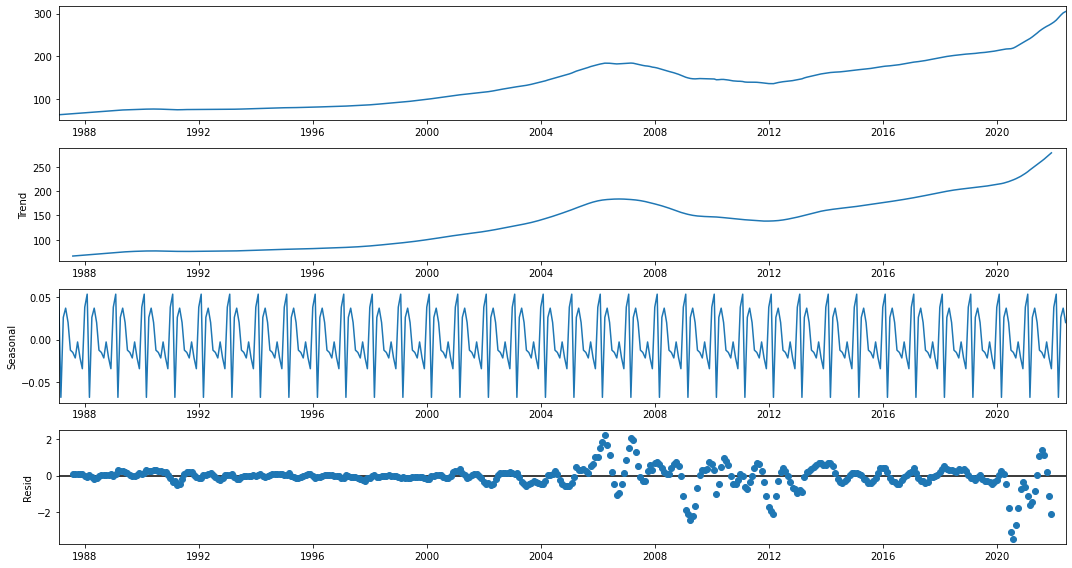

In [20]:
decomp=seasonal_decompose(df1,model='additive')
decomp.plot()
plt.show()

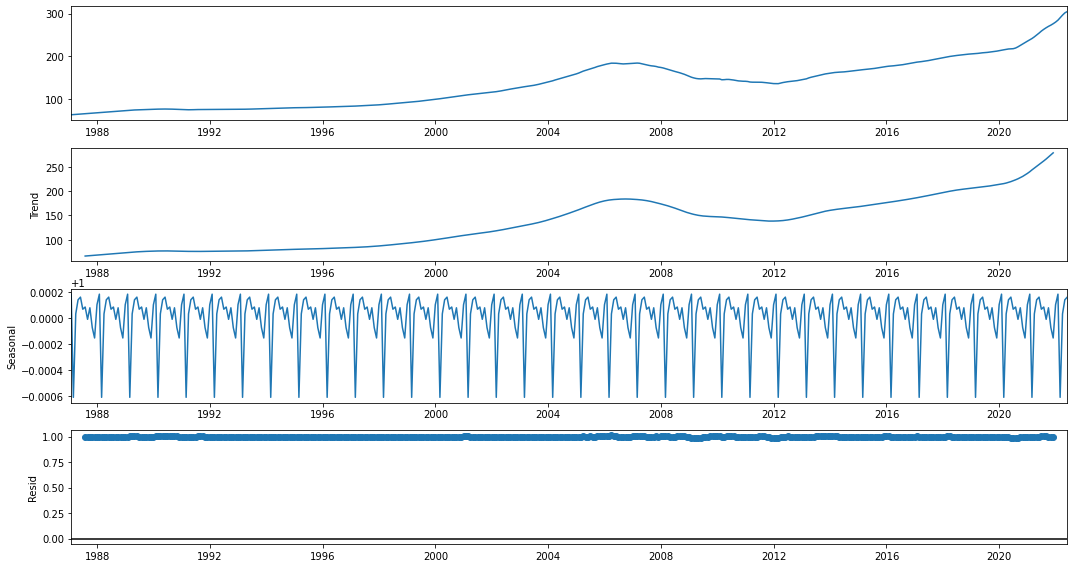

In [21]:
decomp=seasonal_decompose(df1,model='multiplicative')
decomp.plot()
plt.show()

In [22]:
yearly_mean=df1.resample('Y').mean()

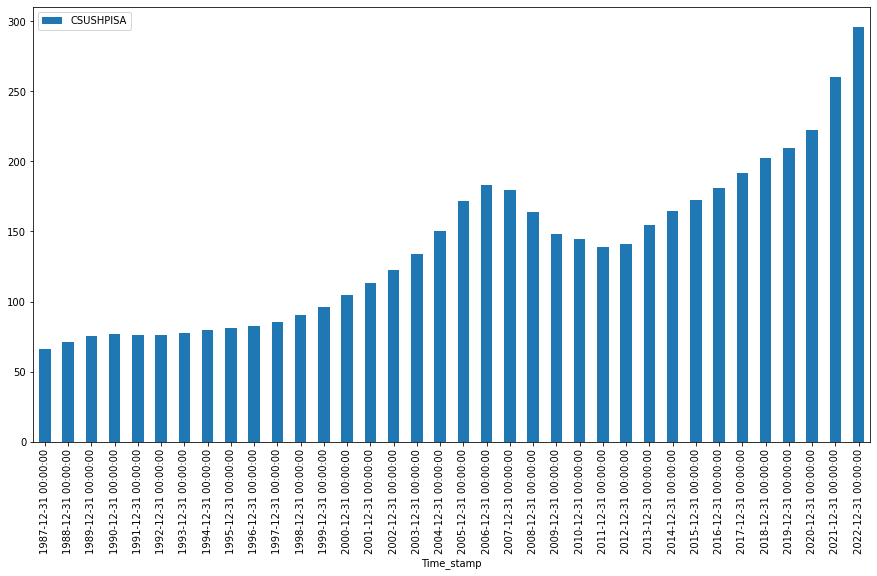

In [23]:
yearly_mean.plot.bar()

In [24]:
rolmean=df1.rolling(window=15).mean()
rolstd=df1.rolling(window=15).std()

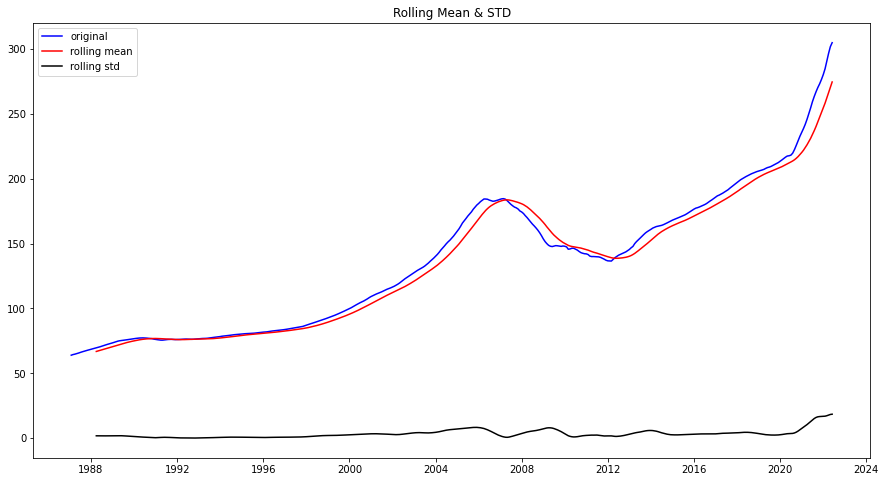

In [25]:
orig=plt.plot(df1,color='blue',label='original')
mean=plt.plot(rolmean,color='red',label='rolling mean')
std=plt.plot(rolstd,color='black',label='rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & STD')
plt.show()

In [26]:
obs=df1['CSUSHPISA']
test_result=adfuller(obs)

In [27]:
print('ADF Statistic:%f' %test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
    print('\t%s: %5f'% (key, value))

ADF Statistic:1.207097
p-value: 0.996035
Critical Values:
	1%: -3.446560
	5%: -2.868685
	10%: -2.570576


Since p_value>0.05 the series is non-stationary. We will use the ARIMA model to address the non-stationarity issue.

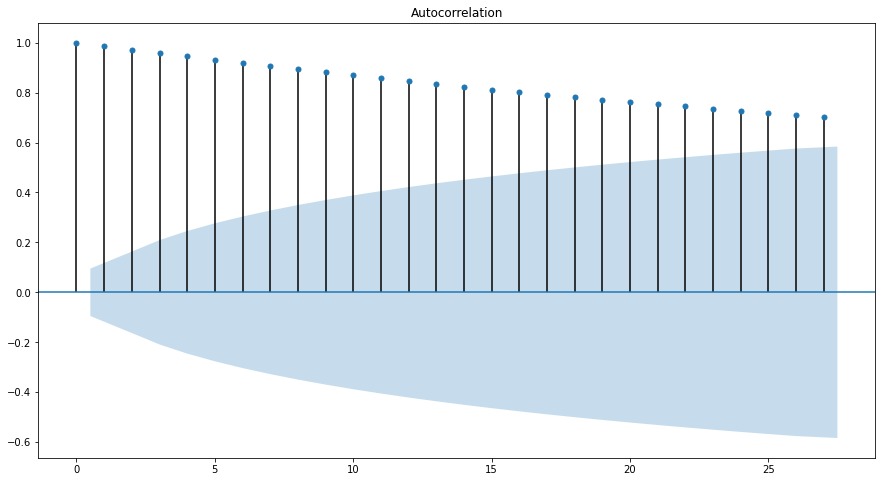

In [28]:
plot_acf(df1);

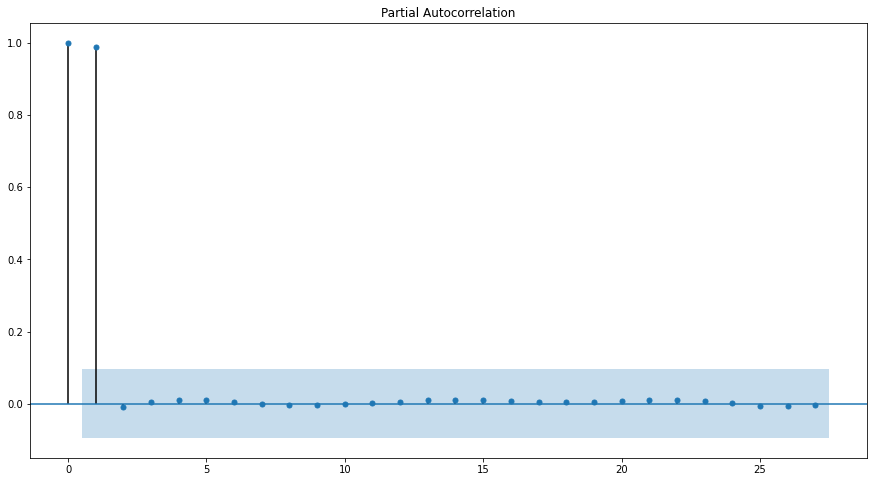

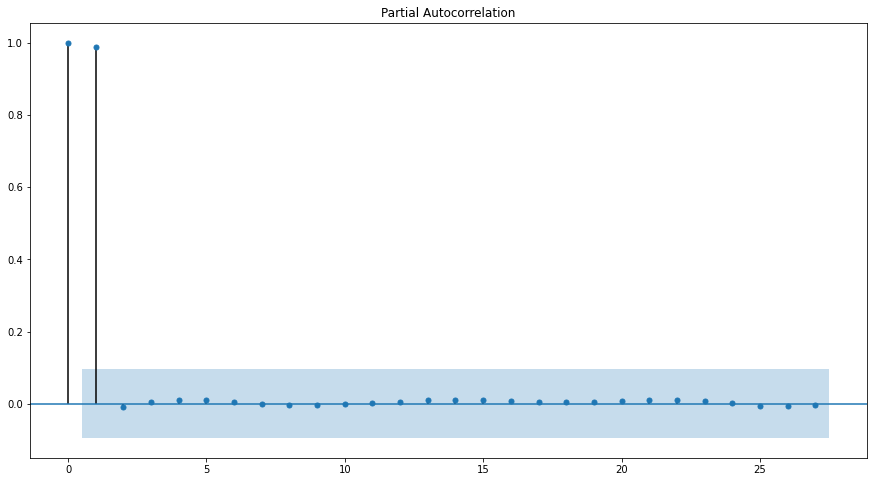

In [29]:
plot_pacf(df1)

In [114]:
train_end=datetime(2021,1,31)
test_end=datetime(2022,1,31)

In [115]:
train=df1[:train_end]
test=df1[train_end + timedelta(days=1):test_end]

In [116]:
train.shape

(409, 1)

In [117]:
test.shape

(12, 1)

***Model Building***

In [120]:
import itertools
p=q=range(0,2)
d=range(0,2)
pdq=list(itertools.product(p,d,q))
model_pdq=[(x[0],x[1],x[2],7) for x in list(itertools.product(p,d,q))]
print('examples of parameter combinations for model...')
print('Model: {}{}'.format(pdq[1],model_pdq[1]))
print('Model: {}{}'.format(pdq[1],model_pdq[2]))
print('Model: {}{}'.format(pdq[2],model_pdq[3]))
print('Model: {}{}'.format(pdq[2],model_pdq[4]))

examples of parameter combinations for model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 1, 0, 7)
Model: (0, 1, 0)(0, 1, 1, 7)
Model: (0, 1, 0)(1, 0, 0, 7)


In [121]:
model_pdq

[(0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7)]

In [123]:
dfObj1=pd.DataFrame(columns=['param','AIC'])
dfObj1

,param,AIC


In [124]:
for param in pdq:
    try:
        mod=ARIMA(train, order=param)
        results_Arima=mod.fit()
        print('ARIMA{}-AIC:{}'.format(param,results_Arima.aic))
        dfObj1=dfObj1.append({'param':param, 'AIC': results_Arima.aic},ignore_index=True)
        
    except:
        continue

ARIMA(0, 0, 0)-AIC:4315.196711949445
ARIMA(0, 0, 1)-AIC:3762.371731513884
ARIMA(0, 1, 0)-AIC:980.1189514105746
ARIMA(0, 1, 1)-AIC:616.0796946199034
ARIMA(1, 0, 0)-AIC:1105.1735919464281
ARIMA(1, 1, 0)-AIC:81.56493130574154
ARIMA(1, 1, 1)-AIC:82.96275135162023


In [125]:
dfObj1.sort_values(by=['AIC'])

,param,AIC
5,"(1, 1, 0)",81.564931
6,"(1, 1, 1)",82.962751
3,"(0, 1, 1)",616.079695
2,"(0, 1, 0)",980.118951
4,"(1, 0, 0)",1105.173592
1,"(0, 0, 1)",3762.371732
0,"(0, 0, 0)",4315.196712


In [126]:
model=ARIMA(train,order=(1,1,1))
model_Arima=model.fit()
print(model_Arima.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.CSUSHPISA   No. Observations:                  408
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -37.481
Method:                       css-mle   S.D. of innovations              0.264
Date:                Wed, 24 Aug 2022   AIC                             82.963
Time:                        15:29:33   BIC                             99.008
Sample:                    02-28-1987   HQIC                            89.312
                         - 01-31-2021                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5426      0.261      2.079      0.038       0.031       1.054
ar.L1.D.CSUSHPISA     0.9496      0.018     54.001      0.000       0.915       0.984
ma.L1.D.CSUSHPISA     0.

In [127]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [128]:
ARIMA_pred=model_Arima.predict(start=pred_start,end=pred_end)

In [129]:
forecast=model_Arima.forecast(len(test))

In [130]:
ARIMA_pred=ARIMA_pred.cumsum()
ARIMA_pred=pd.DataFrame(ARIMA_pred,columns=train.columns)

In [131]:
df2=ARIMA_pred.copy()
columns=train.columns
for col in columns:
    df2[str(col)+'_forecast']=train[col].iloc[-1]+df2[str(col)]

In [132]:
df2.head()

,CSUSHPISA,CSUSHPISA_forecast
2021-02-28,2.963120,241.747120
2021-03-31,5.804304,244.588304
2021-04-30,8.529695,247.313695
2021-05-31,11.145126,249.929126
2021-06-30,13.656136,252.440136


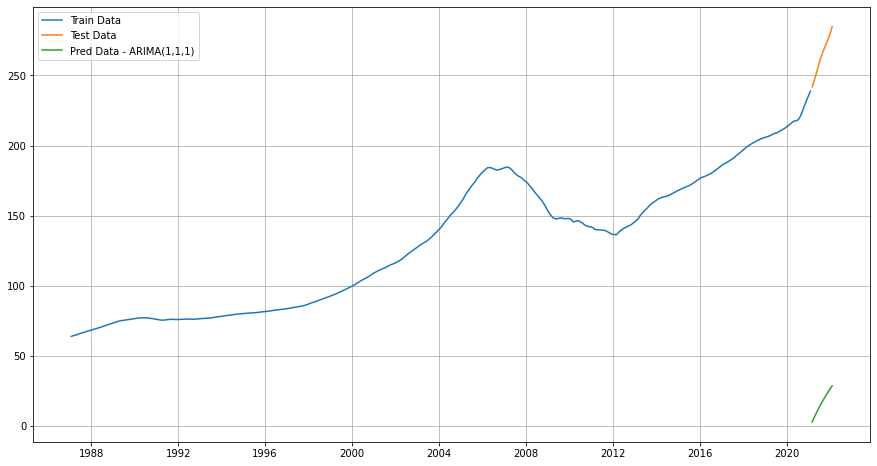

In [133]:
plt.plot(train,label='Train Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df2['CSUSHPISA'],label='Pred Data - ARIMA(1,1,1)')
plt.legend(loc='best')
plt.grid();

In [134]:
residuals=test.CSUSHPISA - df2['CSUSHPISA_forecast']

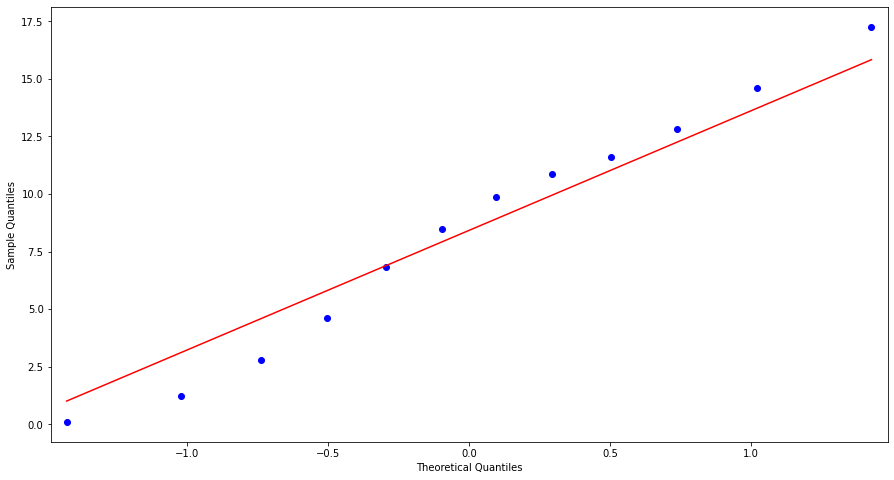

In [135]:
qqplot(residuals,line='s');

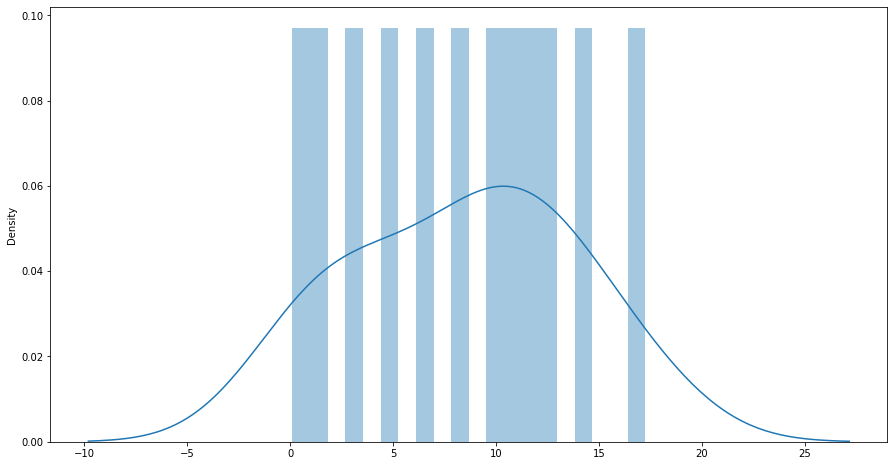

In [136]:
sns.distplot(residuals,bins=20)

In [137]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse=sqrt(mean_squared_error(test.CSUSHPISA,df2['CSUSHPISA_forecast']))
print(rmse)

9.894498769761006


In [138]:
def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [139]:
mape=MAPE(test['CSUSHPISA'].values,df2['CSUSHPISA_forecast'].values)
print(mape)

3.0990178446467778


In [140]:
result=pd.DataFrame({'Test RMSE ': rmse,'Test MAPE':mape},index=['ARIMA(1,1,1)'])
result

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",9.894499,3.099018


Since the RMSE is only 9 , it is good.

In [141]:
import itertools
p=q=range(0,2)
d=range(0,2)
pdq=list(itertools.product(p,d,q))
model_pdq=[(x[0],x[1],x[2],7) for x in list(itertools.product(p,d,q))]
print('examples of parameter combinations for model...')
print('Model: {}{}'.format(pdq[1],model_pdq[1]))
print('Model: {}{}'.format(pdq[1],model_pdq[2]))
print('Model: {}{}'.format(pdq[2],model_pdq[3]))
print('Model: {}{}'.format(pdq[2],model_pdq[4]))

examples of parameter combinations for model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 1, 0, 7)
Model: (0, 1, 0)(0, 1, 1, 7)
Model: (0, 1, 0)(1, 0, 0, 7)


In [142]:
model_pdq

[(0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7)]

In [143]:
dfObj2=pd.DataFrame(columns=['param','AIC'])
dfObj2

,param,AIC


In [144]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod=sm.tsa.statespace.SARIMAX(train,order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
        results_SARIMA=mod.fit()
        print('SARIMA{}x{}7 - AIC{}'.format(param,param_seasonal, results_SARIMA.aic))
        dfObj2=dfObj2.append({'param':param,'seasonal':param_seasonal,'AIC':results_SARIMA.aic},ignore_index=True)

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC5185.8021097762
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC5109.386837111262
SARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC2546.4369565225415
SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC2214.8581854332133
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC2431.5393546065707
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC2163.6663148197167
SARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC1992.6418441589224
SARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC1978.1326840641768
SARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC4619.607316728142
SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC4563.978511854926
SARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC2036.43177752225
SARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC1788.0433284597475
SARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC2440.3047398695526
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC1730.360179914749
SARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC1565.5784686143186
SARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC1558.4799603100448
SARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC1079.0412769380225
SARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC887.5522167273825
SARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC766

In [145]:
dfObj2.sort_values(by=['AIC'])

,param,AIC,seasonal
48,"(1, 1, 0)",80.675827,"(0, 0, 0, 7)"
56,"(1, 1, 1)",82.825970,"(0, 0, 0, 7)"
49,"(1, 1, 0)",84.289624,"(0, 0, 1, 7)"
52,"(1, 1, 0)",84.473346,"(1, 0, 0, 7)"
60,"(1, 1, 1)",86.058977,"(1, 0, 0, 7)"
...,...,...,...
2,"(0, 0, 0)",2546.436957,"(0, 1, 0, 7)"
9,"(0, 0, 1)",4563.978512,"(0, 0, 1, 7)"
8,"(0, 0, 1)",4619.607317,"(0, 0, 0, 7)"
1,"(0, 0, 0)",5109.386837,"(0, 0, 1, 7)"


In [146]:
model=sm.tsa.statespace.SARIMAX(train,order=(1,1,1),
                                      seasonal_order=(1,1,1,7),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
model_Sarima=model.fit()
print(model_Sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         CSUSHPISA   No. Observations:                  409
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 -51.113
Date:                           Wed, 24 Aug 2022   AIC                            112.225
Time:                                   15:32:14   BIC                            132.082
Sample:                               01-31-1987   HQIC                           120.095
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9601      0.016     60.161      0.000       0.929       0.991
ma.L1          0.0430      0.033      1.297

In [147]:
SARIMA_pred=model_Sarima.predict(start=pred_start,end=pred_end)

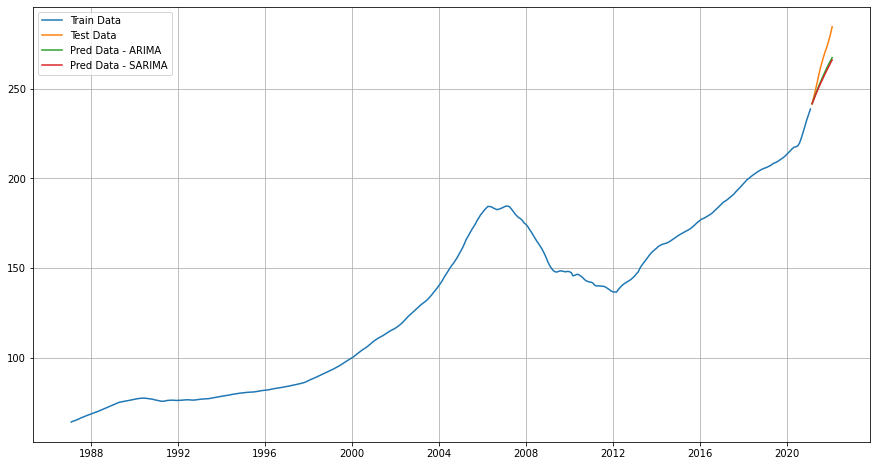

In [148]:
plt.plot(train,label='Train Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df2['CSUSHPISA_forecast'],label='Pred Data - ARIMA')
plt.plot(test.index,SARIMA_pred,label='Pred Data - SARIMA')
plt.legend(loc='best')
plt.grid();

In [149]:
rmse=sqrt(mean_squared_error(test.CSUSHPISA,SARIMA_pred))
print(rmse)

10.906223321446946


In [150]:
mape=MAPE(test['CSUSHPISA'].values,SARIMA_pred)
print(mape)

3.44732437612977


In [151]:
result_sarima=pd.DataFrame({'Test RMSE ': rmse,'Test MAPE':mape},index=['SARIMA(1,1,1)(1,1,1,7)'])
resultdf=pd.concat([result,result_sarima])
resultdf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",9.894499,3.099018
"SARIMA(1,1,1)(1,1,1,7)",10.906223,3.447324


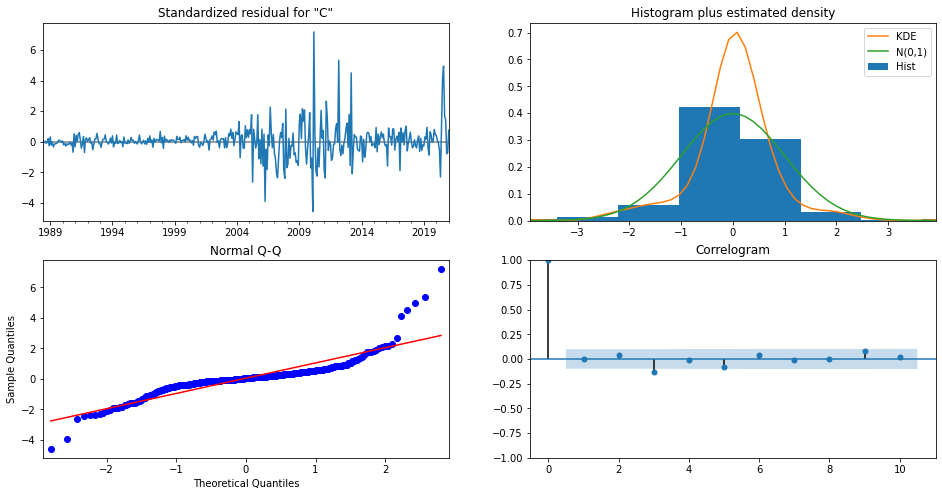

In [152]:
model_Sarima.plot_diagnostics(figsize=(16,8))
plt.show()

In [153]:
model_TES=ExponentialSmoothing(train,trend='additive',seasonal='additive')

In [154]:
model_TES=model_TES.fit(optimized=True)
model_TES.summary()

Dep. Variable:,CSUSHPISA,No. Observations:,409
Model:,ExponentialSmoothing,SSE,26.759
Optimized:,True,AIC,-1083.273
Trend:,Additive,BIC,-1019.054
Seasonal:,Additive,AICC,-1081.519
Seasonal Periods:,12,Date:,"Wed, 24 Aug 2022"
Box-Cox:,False,Time:,15:32:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,1.0000000,beta,True


In [155]:
TES_pred=model_TES.forecast(len(test))

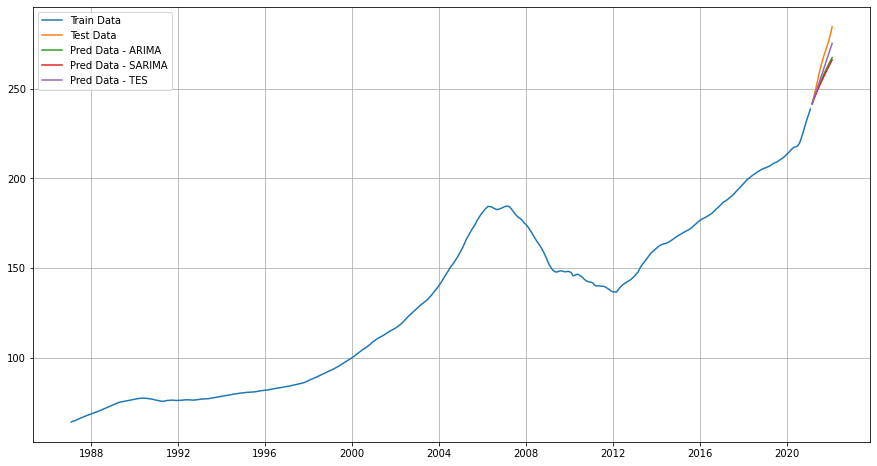

In [156]:
plt.plot(train,label='Train Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df2['CSUSHPISA_forecast'],label='Pred Data - ARIMA')
plt.plot(test.index,SARIMA_pred,label='Pred Data - SARIMA')
plt.plot(test.index,TES_pred,label='Pred Data - TES')
plt.legend(loc='best')
plt.grid();

In [157]:
rmse=sqrt(mean_squared_error(test.CSUSHPISA,TES_pred))
print(rmse)

6.044430594749174


In [158]:
mape=MAPE(test['CSUSHPISA'].values,TES_pred.values)
print(mape)

1.978544140517146


In [159]:
result_tes=pd.DataFrame({'Test RMSE ': rmse,'Test MAPE':mape},index=['TES'])
result=pd.concat([resultdf,result_tes])
result

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",9.894499,3.099018
"SARIMA(1,1,1)(1,1,1,7)",10.906223,3.447324
TES,6.044431,1.978544


TES model has the least rmse when compared to other models so it is the best model.

In [161]:
forecast=model_TES.forecast(50)
forecast

2021-02-28    241.729974
2021-03-31    244.862806
2021-04-30    247.904861
2021-05-31    250.915865
2021-06-30    253.908292
2021-07-31    256.945469
2021-08-31    259.999229
2021-09-30    263.099593
2021-10-31    266.178163
2021-11-30    269.254523
2021-12-31    272.332141
2022-01-31    275.416141
2022-02-28    278.362115
2022-03-31    281.494948
2022-04-30    284.537003
2022-05-31    287.548006
2022-06-30    290.540434
2022-07-31    293.577610
2022-08-31    296.631371
2022-09-30    299.731734
2022-10-31    302.810304
2022-11-30    305.886665
2022-12-31    308.964283
2023-01-31    312.048283
2023-02-28    314.994257
2023-03-31    318.127089
2023-04-30    321.169144
2023-05-31    324.180147
2023-06-30    327.172575
2023-07-31    330.209751
2023-08-31    333.263512
2023-09-30    336.363875
2023-10-31    339.442446
2023-11-30    342.518806
2023-12-31    345.596424
2024-01-31    348.680424
2024-02-29    351.626398
2024-03-31    354.759230
2024-04-30    357.801285
2024-05-31    360.812289
